In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
#Import file
path1=r'C:\Users\Maria\Dropbox (Personal)\DS4A\Datasets\Current\cali_temp_wnv_cases_2.csv'

df=pd.read_csv(path1)
df.head()
df.drop(columns=['Unnamed: 0'], inplace=True)

county_df=df.groupby(['county']).sum()
#county_df[county_df.index=='ventura']

#sum case counts by county
county_df=df.groupby(['county']).sum()

#Make list of counties with zero cases
zero=county_df[county_df['case_count']==0]
zero_list=zero.index.to_list()


In [3]:
#remove counties with zero case counts
df2 = df[~df['county'].isin(zero_list)]
df2['county'].value_counts()
df2.head()
df=df2.copy()

#Set mmwr_endate as index and datetime
df.set_index('mmwr_enddate', inplace=True)
df.index = pd.to_datetime(df.index)

#Add month and year columns
df['month']=df.index.month
df['year']=df.index.year

df.reset_index(inplace=True)
df.drop(columns=['mmwr_enddate'], inplace=True)
df.head()

#Agr=gregate by year and month
new=df.groupby(['year','month']).aggregate({'ppt (mm)':'sum','tmean (degrees C)': 'mean','case_count':'sum' })
new.reset_index(inplace=True)
new.head()

#Make day column to create a datetime column using month, day, and year.
new['day']="1"
new["month_date"] = pd.to_datetime(new[['month', 'day', 'year']])

df=new.drop(columns=['year', 'month', 'day'])
df.set_index('month_date', inplace=True)
df.rename(columns={'tmean (degrees C)':'mean_temp', 'ppt (mm)':'percip'}, inplace=True)
df.tail()

#Shift dataset by two periods since there was a two month lag in the two peaks of temp and case_count
df['mean_temp_shift']=df['mean_temp'].shift(periods=2)

#to get rid of NAN
df=df.drop(['2006-01-01','2006-02-01'])

df.head()

,percip,mean_temp,case_count,mean_temp_shift
month_date,,,,
2006-03-01,1354.942857,7.464359,0.0,8.094534
2006-04-01,1341.258571,11.175102,0.0,9.310641
2006-05-01,149.468571,18.257434,0.0,7.464359
2006-06-01,12.394286,20.365233,1.0,11.175102
2006-07-01,7.182857,26.075102,15.0,18.257434


# Power Law

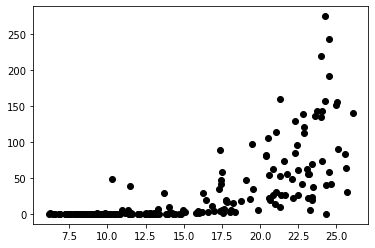

In [4]:
#define independent and dependent variables
x=df.mean_temp_shift
y=df.case_count	

#define power law expression
def power_law(x, a, b):
    return a*np.power(x, b)

#fit curve 
popt, pcov = curve_fit(power_law, x, y)
plt.plot(x,y,'ok')

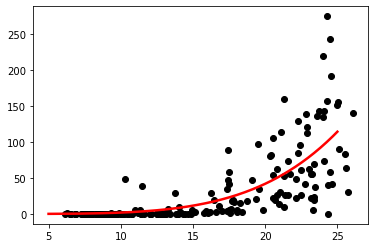

In [5]:
#Plot power law trendline vs scatter plot of cases by temperature
x=df.mean_temp_shift
popt, pcov = curve_fit(power_law, x, y)
plt.plot(x,y,'ok')

x = np.linspace(5, 25, len(x))
plt.plot(x, power_law(x, *popt),'r-',markersize=3,  linewidth=2.5)

In [6]:
#calculate r^2

x=df.mean_temp_shift

residuals = y - power_law(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

r_squared

0.5510121436934113

In [10]:
popt

array([5.88801913e-05, 4.49829336e+00])

In [18]:
#store constants to be used in model
a=popt[0]
b=popt[1]

In [8]:
pcov

array([[ 1.11133379e-08, -5.98735804e-05],
       [-5.98735804e-05,  3.22839906e-01]])

In [19]:
#Use constants to define model
def powmodel(x):
    return str(round(a*(x**b))) + ' cases'

#predict
powmodel(17)

'20 cases'

In [ ]:
#Next step: Model Validation